In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

import sklearn
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import torch
import torch.nn as nn

from transformers import AutoTokenizer, AutoModel

# Read Data

In [2]:
course_dict = pd.read_pickle('./review_data')
courses = course_dict.keys()
course_df = pd.DataFrame(columns=
                         ["Course", "Term", "Comment", "Learning", 
                          "Difficulty", "Instructor", "Instructor_Names"]
                        )
idx = 0
with tqdm(total=len(course_dict.keys())) as pbar:
    for key, instructors_reviews in course_dict.items():
        term, course = key
        instructor_names = instructors_reviews[0]
        comment_list = instructors_reviews[1]
        for curr_comment in comment_list:
    #         print(idx, curr_comment, type(curr_comment))
            curr_row = pd.DataFrame([[course, term, curr_comment, 0, 0, 0, instructor_names]],
                                    columns = ["Course", "Term", "Comment", "Learning", 
                                               "Difficulty", "Instructor", "Instructor_Names"],
                                    index=[idx]
                            )
            course_df = course_df.append(curr_row)
            idx += 1
        pbar.update(1)
print(course_df)

ValueError: unsupported pickle protocol: 5

# Heuristic Label

In [24]:
keywords = {
#     "fun":["very fun", "very enjoyable", "super fun class"],
#     "not fun": ["not fun at all"],
    
    
    "+ Difficulty":["very difficult", 
                  "take a lot of time",
                  "is a LOT of work", 
                  "very challenging",
                  "start assignments early", 
                  "a lot of work", 
                  "time consuming",
                  "extremely packed", 
                  "consumes a lot of time", 
                  "huge workload",
                  "challenging", 
                  "difficult", 
                  "hard", 
                  "struggle"
                 ],
    "- Difficulty":["not too much work", 
                     "not too challenging", 
                     "not to hard",
                     "easy class",
                     "small workload", 
                     "chill class", 
                     "easy course", 
                     "light workload",
                     "easy"
                    ],
    
    
#     "waste of time":["waste of time", "not worth it"],
    
    
    "+ Instructor":["very supportive", 
                  "very well-taught", 
                  "really supported", 
                  "amazing instructor", 
                  "instructor was very knowledgable", 
                  "very well taught", 
                  "is a very good teacher", 
                  "very well-designed",
                  "one of the best professors", 
                  "amazing professor", 
                  "the most knowledgeable",
                   "not well taught",
                   ],
    "- Instructor":["don't take it with", 
                      "the worst teacher", 
                      "learn on your own", 
                      "figure out on your own", 
                      "feels unorganized",
                        "not well taught",
                   ],
    
    
    "+ Learning":["useful assignments", 
                "learned a lot",
                "learn a lot", 
                "learn important skills", 
                "extremely useful",
                "very useful" 
                "a lot of work but worth it", 
                "assignments were useful", 
                "hands on", 
                "accomplished", 
                "accomplishment", 
                "foundation", 
                "learn", 
                "building block", 
                "helpful", 
                "covers"
               ],
    "- Learning":[ "only at a surface level", 
                   "shallow", 
                   "won't dive into much detail", 
                   "don't learn much", 
                   "introductory", 
                   "boring",
                  ],
    
    
#     "no background requirement":["nice introduction", "nice introductory", "very approachable introduction","very accessible","good survey", "good intro class", "nice intro class",
#                              ],
#     "requires background":["not an intro class", "not an introductory class"],
#     "positive":["take it", "would recommend"],
#     "negative":["don't take it", "wouldn't recommend"]
}

In [25]:
# Naive Loop Approach
num_rows = course_df.shape[0]
attributes = ["Difficulty", "Instructor", "Learning"]

for idx in tqdm(range(num_rows)):
    curr_row = course_df.iloc[idx]
    curr_comment = curr_row["Comment"]
#     print(curr_comment)
    for curr_attr in attributes:
        attr = sum([1 if phrase in curr_comment else 0 for phrase in keywords[f"+ {curr_attr}"]]) \
            - sum([1 if phrase in curr_comment else 0 for phrase in keywords[f"- {curr_attr}"]])
        curr_row[curr_attr] = attr
#     print(course_df.iloc[idx], curr_row)
    course_df.iloc[idx] = curr_row # maybe we can change row in place instead?
course_df

  0%|                                                                                        | 0/22372 [00:00<?, ?it/s]<ipython-input-25-6a8a7b8f2d68>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_row[curr_attr] = attr
100%|██████████████████████████████████████████████████████████████████████████| 22372/22372 [00:04<00:00, 5567.28it/s]


,Course,Term,Comment,Learning,Difficulty,Instructor,Instructor_Names
0,CS352,Sp17,A nice and fun class with small time commitmen...,0,0,0,{OmerReingold}
1,CS352,Sp17,Its an interesting course on understanding how...,0,0,0,{OmerReingold}
2,CS352,Sp17,You need to have done well in CS 154 and in CS...,0,0,0,{OmerReingold}
3,CS352,Sp17,I would recommend taking CS265 and CS154 befo...,1,0,0,{OmerReingold}
4,CS352,Sp17,Take it! The material in this course has been...,1,0,0,{OmerReingold}
...,...,...,...,...,...,...,...
22367,CS190,W19,Perhaps my favorite course at Stanford. Many o...,1,0,0,{JohnOusterhout}
22368,CS190,W19,Best CS class I've taken! John gives code revi...,1,0,0,{JohnOusterhout}
22369,CS190,W19,I would definitely recommend taking this cours...,0,0,0,{JohnOusterhout}
22370,CS190,W19,This is really more of a software engineering ...,0,0,0,{JohnOusterhout}


In [56]:
print(course_df.iloc[25765])

Course                                                                                                                                                                                                       CS%20109
Comment       This class is so hard but so rewarding. Chris Piech is an incredible lecturer and really makes the content feel relevant and interesting. The problem sets can be very difficult and time consuming,...
Learning                                                                                                                                                                                                            0
Difficulty                                                                                                                                                                                                          4
Instructor                                                                                                                                      

In [55]:
print(course_df.loc[course_df["Difficulty"]==0]["Comment"])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
course_df.sort_values("Difficulty")

,Course,Comment,Learning,Difficulty,Instructor
9088,CS%20227B,Class is not well taught and you don't learn a...,1,-3,0
19325,CS%20157,"It is a chill class, all the lessons needed to...",0,-3,0
6062,CS%20145,Fairly easy course that gives a light overview...,1,-2,0
1396,CS%20105,"Regardless of coding experience, it's a very e...",0,-2,0
21887,CS%20255,"If you're a Math major, then this will be an e...",0,-2,0
...,...,...,...,...,...
25765,CS%20109,This class is so hard but so rewarding. Chris ...,0,4,0
26037,CS%20110,It is a very challenging course and the homewo...,0,4,0
24431,CS%20103,"Take it! But be sure to pay attention, work ha...",0,4,0
11884,CS%20238,The professor is super nice and very willing t...,0,4,0


In [26]:
course_df["Difficulty"].value_counts()

 0    17635
 1     3553
 2      631
-1      417
 3       77
-2       50
 4        8
-3        1
Name: Difficulty, dtype: int64

# Visualize Data

In [27]:
# Comment Attribute Visualization

def plot_comment_attr(df, attribute):
    count_series = df[attribute].value_counts()
    count_map = count_series.to_dict()
    
    x = count_map.keys()
    heights = count_map.values()
    
    plt.title(f"{attribute} values")
    plt.bar(x, heights)
    plt.show()

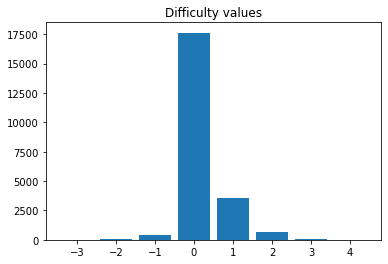

In [28]:
plot_comment_attr(course_df, "Difficulty")

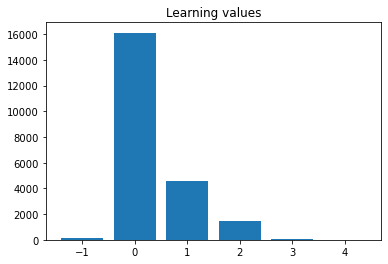

In [29]:
plot_comment_attr(course_df, "Learning")

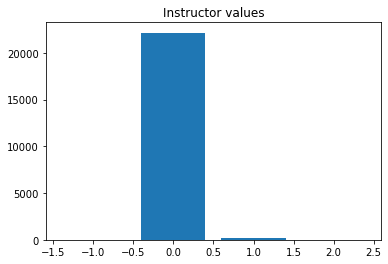

In [30]:
plot_comment_attr(course_df, "Instructor")

# Split Data

In [2]:
course_features = course_df["Comments"]
instr_labels = course_df["Instructor"]
dif_labels = course_df["Difficulty"]
learn_labels = course_df["Learning"]

# For every attribute, split data stratified by label
instr_x_train, instr_x_test, instr_y_train, instr_y_test = train_test_split(course_features,
                                                                            instr_labels,
                                                                            test_size=0.1,
                                                                            random_state=42)

dif_x_train, dif_x_test, dif_y_train, dif_y_test = train_test_split(course_features,
                                                                            dif_labels,
                                                                            test_size=0.1,
                                                                            random_state=42)

learn_x_train, learn_x_test, learn_y_train, learn_y_test = train_test_split(course_features,
                                                                            learn_labels,
                                                                            test_size=0.1,
                                                                            random_state=42)

print(learn_x_train, learn_y_train)

NameError: name 'course_df' is not defined

# Initialize Bert

In [ ]:
# Initializing a trained RoBERTa

model = AutoModel.from_pretrained("roberta-base")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

# Train Bert

In [ ]:
# Train Difficulty Model

diff_classifier = pass
for i in range(iters):  # tqdm
    batch = input_sentences[i*20:(i+1)*20]
    inputs = self.tokenizer(batch, return_tensors="pt", padding='max_length', truncation=True, max_length=100)
    
    encoded = self.model(**inputs)

# Infer